
<a id='ppd'></a>
<div id="qe-notebook-header" align="right" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" width="250px" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>

# Pandas for Panel Data


<a id='index-1'></a>

## Contents

- [Pandas for Panel Data](#Pandas-for-Panel-Data)  
  - [Overview](#Overview)  
  - [Slicing and Reshaping Data](#Slicing-and-Reshaping-Data)  
  - [Merging Dataframes and Filling NaNs](#Merging-Dataframes-and-Filling-NaNs)  
  - [Grouping and Summarizing Data](#Grouping-and-Summarizing-Data)  
  - [Final Remarks](#Final-Remarks)  
  - [Exercises](#Exercises)  
  - [Solutions](#Solutions)  

## Overview

In an [earlier lecture on pandas](https://python.quantecon.org/pandas.html), we looked at working with simple data sets.

Econometricians often need to work with more complex data sets, such as panels.

Common tasks include

- Importing data, cleaning it and reshaping it across several axes.  
- Selecting a time series or cross-section from a panel.  
- Grouping and summarizing data.  


`pandas` (derived from ‘panel’ and ‘data’) contains powerful and
easy-to-use tools for solving exactly these kinds of problems.

In what follows, we will use a panel data set of real minimum wages from the OECD to create:

- summary statistics over multiple dimensions of our data  
- a time series of the average minimum wage of countries in the dataset  
- kernel density estimates of wages by continent  


We will begin by reading in our long format panel data from a CSV file and
reshaping the resulting `DataFrame` with `pivot_table` to build a `MultiIndex`.

Additional detail will be added to our `DataFrame` using pandas’
`merge` function, and data will be summarized with the `groupby`
function.

Most of this lecture was created by [Natasha Watkins](https://github.com/natashawatkins).

## Slicing and Reshaping Data

We will read in a dataset from the OECD of real minimum wages in 32
countries and assign it to `realwage`.

The dataset `pandas_panel/realwage.csv` can be downloaded
<a href=_static/lecture_specific/pandas_panel/realwage.csv download>here</a>.

Make sure the file is in your current working directory

In [1]:
import pandas as pd

# Display 6 columns for viewing purposes
pd.set_option('display.max_columns', 6)

# Reduce decimal points to 2
pd.options.display.float_format = '{:,.2f}'.format

realwage = pd.read_csv('https://github.com/QuantEcon/QuantEcon.lectures.code/raw/master/pandas_panel/realwage.csv')

Let’s have a look at what we’ve got to work with

In [2]:
realwage.head()  # Show first 5 rows

,Unnamed: 0,Time,Country,Series,Pay period,value
0,0,2006-01-01,Ireland,In 2015 constant prices at 2015 USD PPPs,Annual,"17,132.44"
1,1,2007-01-01,Ireland,In 2015 constant prices at 2015 USD PPPs,Annual,"18,100.92"
2,2,2008-01-01,Ireland,In 2015 constant prices at 2015 USD PPPs,Annual,"17,747.41"
3,3,2009-01-01,Ireland,In 2015 constant prices at 2015 USD PPPs,Annual,"18,580.14"
4,4,2010-01-01,Ireland,In 2015 constant prices at 2015 USD PPPs,Annual,"18,755.83"


The data is currently in long format, which is difficult to analyze when there are several dimensions to the data.

We will use `pivot_table` to create a wide format panel, with a `MultiIndex` to handle higher dimensional data.

`pivot_table` arguments should specify the data (values), the index, and the columns we want in our resulting dataframe.

By passing a list in columns, we can create a `MultiIndex` in our column axis

In [3]:
realwage = realwage.pivot_table(values='value',
                                index='Time',
                                columns=['Country', 'Series', 'Pay period'])
realwage.head()

Country                                   Australia         \
Series     In 2015 constant prices at 2015 USD PPPs          
Pay period                                   Annual Hourly   
Time                                                         
2006-01-01                                20,410.65  10.33   
2007-01-01                                21,087.57  10.67   
2008-01-01                                20,718.24  10.48   
2009-01-01                                20,984.77  10.62   
2010-01-01                                20,879.33  10.57   

Country                                                        ...  \
Series     In 2015 constant prices at 2015 USD exchange rates  ...   
Pay period                                             Annual  ...   
Time                                                           ...   
2006-01-01                                          23,826.64  ...   
2007-01-01                                          24,616.84  ...   
2008-01-01                                          24,185.70  ...   
2009-01-01                                          24,496.84  ...   
2010-01-01                                          24,373.76  ...   

Country                               United States  \
Series     In 2015 constant prices at 2015 USD PPPs   
Pay period                                   Hourly   
Time                                                  
2006-01-01                                     6.05   
2007-01-01                                     6.24   
2008-01-01                                     6.78   
2009-01-01                                     7.58   
2010-01-01                                     7.88   

Country                                                               
Series     In 2015 constant prices at 2015 USD exchange rates         
Pay period                                             Annual Hourly  
Time                                                                  
2006-01-01                                          12,594.40   6.05  
2007-01-01                                          12,974.40   6.24  
2008-01-01                                          14,097.56   6.78  
2009-01-01                                          15,756.42   7.58  
2010-01-01                                          16,391.31   7.88  

[5 rows x 128 columns]

To more easily filter our time series data, later on, we will convert the index into a `DateTimeIndex`

In [4]:
realwage.index = pd.to_datetime(realwage.index)
type(realwage.index)

pandas.core.indexes.datetimes.DatetimeIndex

The columns contain multiple levels of indexing, known as a
`MultiIndex`, with levels being ordered hierarchically (Country >
Series > Pay period).

A `MultiIndex` is the simplest and most flexible way to manage panel
data in pandas

In [5]:
type(realwage.columns)

pandas.core.indexes.multi.MultiIndex

In [6]:
realwage.columns.names

FrozenList(['Country', 'Series', 'Pay period'])

Like before, we can select the country (the top level of our
`MultiIndex`)

In [7]:
realwage['United States'].head()

Series     In 2015 constant prices at 2015 USD PPPs         \
Pay period                                   Annual Hourly   
Time                                                         
2006-01-01                                12,594.40   6.05   
2007-01-01                                12,974.40   6.24   
2008-01-01                                14,097.56   6.78   
2009-01-01                                15,756.42   7.58   
2010-01-01                                16,391.31   7.88   

Series     In 2015 constant prices at 2015 USD exchange rates         
Pay period                                             Annual Hourly  
Time                                                                  
2006-01-01                                          12,594.40   6.05  
2007-01-01                                          12,974.40   6.24  
2008-01-01                                          14,097.56   6.78  
2009-01-01                                          15,756.42   7.58  
2010-01-01                                          16,391.31   7.88

Stacking and unstacking levels of the `MultiIndex` will be used
throughout this lecture to reshape our dataframe into a format we need.

`.stack()` rotates the lowest level of the column `MultiIndex` to
the row index (`.unstack()` works in the opposite direction - try it
out)

In [8]:
realwage.stack().head()

Country                                              Australia  \
Series                In 2015 constant prices at 2015 USD PPPs   
Time       Pay period                                            
2006-01-01 Annual                                    20,410.65   
           Hourly                                        10.33   
2007-01-01 Annual                                    21,087.57   
           Hourly                                        10.67   
2008-01-01 Annual                                    20,718.24   

Country                                                                   \
Series                In 2015 constant prices at 2015 USD exchange rates   
Time       Pay period                                                      
2006-01-01 Annual                                              23,826.64   
           Hourly                                                  12.06   
2007-01-01 Annual                                              24,616.84   
           Hourly                                                  12.46   
2008-01-01 Annual                                              24,185.70   

Country                                                Belgium  ...  \
Series                In 2015 constant prices at 2015 USD PPPs  ...   
Time       Pay period                                           ...   
2006-01-01 Annual                                    21,042.28  ...   
           Hourly                                        10.09  ...   
2007-01-01 Annual                                    21,310.05  ...   
           Hourly                                        10.22  ...   
2008-01-01 Annual                                    21,416.96  ...   

Country                                                   United Kingdom  \
Series                In 2015 constant prices at 2015 USD exchange rates   
Time       Pay period                                                      
2006-01-01 Annual                                              20,376.32   
           Hourly                                                   9.81   
2007-01-01 Annual                                              20,954.13   
           Hourly                                                  10.07   
2008-01-01 Annual                                              20,902.87   

Country                                          United States  \
Series                In 2015 constant prices at 2015 USD PPPs   
Time       Pay period                                            
2006-01-01 Annual                                    12,594.40   
           Hourly                                         6.05   
2007-01-01 Annual                                    12,974.40   
           Hourly                                         6.24   
2008-01-01 Annual                                    14,097.56   

Country                                                                   
Series                In 2015 constant prices at 2015 USD exchange rates  
Time       Pay period                                                     
2006-01-01 Annual                                              12,594.40  
           Hourly                                                   6.05  
2007-01-01 Annual                                              12,974.40  
           Hourly                                                   6.24  
2008-01-01 Annual                                              14,097.56  

[5 rows x 64 columns]

We can also pass in an argument to select the level we would like to
stack

In [9]:
realwage.stack(level='Country').head()

Series               In 2015 constant prices at 2015 USD PPPs         \
Pay period                                             Annual Hourly   
Time       Country                                                     
2006-01-01 Australia                                20,410.65  10.33   
           Belgium                                  21,042.28  10.09   
           Brazil                                    3,310.51   1.41   
           Canada                                   13,649.69   6.56   
           Chile                                     5,201.65   2.22   

Series               In 2015 constant prices at 2015 USD exchange rates         
Pay period                                                       Annual Hourly  
Time       Country                                                              
2006-01-01 Australia                                          23,826.64  12.06  
           Belgium                                            20,228.74   9.70  
           Brazil                                              2,032.87   0.87  
           Canada                                             14,335.12   6.89  
           Chile                                               3,333.76   1.42

Using a `DatetimeIndex` makes it easy to select a particular time
period.

Selecting one year and stacking the two lower levels of the
`MultiIndex` creates a cross-section of our panel data

In [10]:
realwage['2015'].stack(level=(1, 2)).transpose().head()

Time                                     2015-01-01         \
Series     In 2015 constant prices at 2015 USD PPPs          
Pay period                                   Annual Hourly   
Country                                                      
Australia                                 21,715.53  10.99   
Belgium                                   21,588.12  10.35   
Brazil                                     4,628.63   2.00   
Canada                                    16,536.83   7.95   
Chile                                      6,633.56   2.80   

Time                                                                  
Series     In 2015 constant prices at 2015 USD exchange rates         
Pay period                                             Annual Hourly  
Country                                                               
Australia                                           25,349.90  12.83  
Belgium                                             20,753.48   9.95  
Brazil                                               2,842.28   1.21  
Canada                                              17,367.24   8.35  
Chile                                                4,251.49   1.81

For the rest of lecture, we will work with a dataframe of the hourly
real minimum wages across countries and time, measured in 2015 US
dollars.

To create our filtered dataframe (`realwage_f`), we can use the `xs`
method to select values at lower levels in the multiindex, while keeping
the higher levels (countries in this case)

In [11]:
realwage_f = realwage.xs(('Hourly', 'In 2015 constant prices at 2015 USD exchange rates'),
                         level=('Pay period', 'Series'), axis=1)
realwage_f.head()

Country,Australia,Belgium,Brazil,...,Turkey,United Kingdom,United States
Time,,,,,,,
2006-01-01,12.06,9.70,0.87,...,2.27,9.81,6.05
2007-01-01,12.46,9.82,0.92,...,2.26,10.07,6.24
2008-01-01,12.24,9.87,0.96,...,2.22,10.04,6.78
2009-01-01,12.40,10.21,1.03,...,2.28,10.15,7.58
2010-01-01,12.34,10.05,1.08,...,2.30,9.96,7.88


## Merging Dataframes and Filling NaNs

Similar to relational databases like SQL, pandas has built in methods to
merge datasets together.

Using country information from
[WorldData.info](https://www.worlddata.info/downloads/), we’ll add
the continent of each country to `realwage_f` with the `merge`
function.

The CSV file can be found in `pandas_panel/countries.csv` and can be downloaded
<a href=_static/lecture_specific/pandas_panel/countries.csv download>here</a>.

In [12]:
worlddata = pd.read_csv('https://github.com/QuantEcon/QuantEcon.lectures.code/raw/master/pandas_panel/countries.csv', sep=';')
worlddata.head()

,Country (en),Country (de),Country (local),...,Deathrate,Life expectancy,Url
0,Afghanistan,Afghanistan,Afganistan/Afqanestan,...,13.70,51.30,https://www.laenderdaten.info/Asien/Afghanista...
1,Egypt,Ägypten,Misr,...,4.70,72.70,https://www.laenderdaten.info/Afrika/Aegypten/...
2,Åland Islands,Ålandinseln,Åland,...,0.00,0.00,https://www.laenderdaten.info/Europa/Aland/ind...
3,Albania,Albanien,Shqipëria,...,6.70,78.30,https://www.laenderdaten.info/Europa/Albanien/...
4,Algeria,Algerien,Al-Jaza’ir/Algérie,...,4.30,76.80,https://www.laenderdaten.info/Afrika/Algerien/...


First, we’ll select just the country and continent variables from
`worlddata` and rename the column to ‘Country’

In [13]:
worlddata = worlddata[['Country (en)', 'Continent']]
worlddata = worlddata.rename(columns={'Country (en)': 'Country'})
worlddata.head()

,Country,Continent
0,Afghanistan,Asia
1,Egypt,Africa
2,Åland Islands,Europe
3,Albania,Europe
4,Algeria,Africa


We want to merge our new dataframe, `worlddata`, with `realwage_f`.

The pandas `merge` function allows dataframes to be joined together by
rows.

Our dataframes will be merged using country names, requiring us to use
the transpose of `realwage_f` so that rows correspond to country names
in both dataframes

In [14]:
realwage_f.transpose().head()

Time,2006-01-01,2007-01-01,2008-01-01,...,2014-01-01,2015-01-01,2016-01-01
Country,,,,,,,
Australia,12.06,12.46,12.24,...,12.67,12.83,12.98
Belgium,9.70,9.82,9.87,...,10.01,9.95,9.76
Brazil,0.87,0.92,0.96,...,1.21,1.21,1.24
Canada,6.89,6.96,7.24,...,8.22,8.35,8.48
Chile,1.42,1.45,1.44,...,1.76,1.81,1.91


We can use either left, right, inner, or outer join to merge our
datasets:

- left join includes only countries from the left dataset  
- right join includes only countries from the right dataset  
- outer join includes countries that are in either the left and right datasets  
- inner join includes only countries common to both the left and right datasets  


By default, `merge` will use an inner join.

Here we will pass `how='left'` to keep all countries in
`realwage_f`, but discard countries in `worlddata` that do not have
a corresponding data entry `realwage_f`.

This is illustrated by the red shading in the following diagram

<img src="https://s3-ap-southeast-2.amazonaws.com/python.quantecon.org/_static/lecture_specific/pandas_panel/venn_diag.png" style="">

  
We will also need to specify where the country name is located in each
dataframe, which will be the `key` that is used to merge the
dataframes ‘on’.

Our ‘left’ dataframe (`realwage_f.transpose()`) contains countries in
the index, so we set `left_index=True`.

Our ‘right’ dataframe (`worlddata`) contains countries in the
‘Country’ column, so we set `right_on='Country'`

In [15]:
merged = pd.merge(realwage_f.transpose(), worlddata,
                  how='left', left_index=True, right_on='Country')
merged.head()

,2006-01-01 00:00:00,2007-01-01 00:00:00,2008-01-01 00:00:00,...,2016-01-01 00:00:00,Country,Continent
17.00,12.06,12.46,12.24,...,12.98,Australia,Australia
23.00,9.70,9.82,9.87,...,9.76,Belgium,Europe
32.00,0.87,0.92,0.96,...,1.24,Brazil,South America
100.00,6.89,6.96,7.24,...,8.48,Canada,North America
38.00,1.42,1.45,1.44,...,1.91,Chile,South America


Countries that appeared in `realwage_f` but not in `worlddata` will
have `NaN` in the Continent column.

To check whether this has occurred, we can use `.isnull()` on the
continent column and filter the merged dataframe

In [16]:
merged[merged['Continent'].isnull()]

,2006-01-01 00:00:00,2007-01-01 00:00:00,2008-01-01 00:00:00,...,2016-01-01 00:00:00,Country,Continent
nan,3.42,3.74,3.87,...,5.28,Korea,NaN
nan,0.23,0.45,0.39,...,0.55,Russian Federation,NaN
nan,1.50,1.64,1.71,...,2.08,Slovak Republic,NaN


We have three missing values!

One option to deal with NaN values is to create a dictionary containing
these countries and their respective continents.

`.map()` will match countries in `merged['Country']` with their
continent from the dictionary.

Notice how countries not in our dictionary are mapped with `NaN`

In [17]:
missing_continents = {'Korea': 'Asia',
                      'Russian Federation': 'Europe',
                      'Slovak Republic': 'Europe'}

merged['Country'].map(missing_continents)

17.00        NaN
23.00        NaN
32.00        NaN
100.00       NaN
38.00        NaN
108.00       NaN
41.00        NaN
225.00       NaN
53.00        NaN
58.00        NaN
45.00        NaN
68.00        NaN
233.00       NaN
86.00        NaN
88.00        NaN
91.00        NaN
nan         Asia
117.00       NaN
122.00       NaN
123.00       NaN
138.00       NaN
153.00       NaN
151.00       NaN
174.00       NaN
175.00       NaN
nan       Europe
nan       Europe
198.00       NaN
200.00       NaN
227.00       NaN
241.00       NaN
240.00       NaN
Name: Country, dtype: object

We don’t want to overwrite the entire series with this mapping.

`.fillna()` only fills in `NaN` values in `merged['Continent']`
with the mapping, while leaving other values in the column unchanged

In [18]:
merged['Continent'] = merged['Continent'].fillna(merged['Country'].map(missing_continents))

# Check for whether continents were correctly mapped

merged[merged['Country'] == 'Korea']

,2006-01-01 00:00:00,2007-01-01 00:00:00,2008-01-01 00:00:00,...,2016-01-01 00:00:00,Country,Continent
nan,3.42,3.74,3.87,...,5.28,Korea,Asia


We will also combine the Americas into a single continent - this will make our visualization nicer later on.

To do this, we will use `.replace()` and loop through a list of the continent values we want to replace

In [19]:
replace = ['Central America', 'North America', 'South America']

for country in replace:
    merged['Continent'].replace(to_replace=country,
                                value='America',
                                inplace=True)

Now that we have all the data we want in a single `DataFrame`, we will
reshape it back into panel form with a `MultiIndex`.

We should also ensure to sort the index using `.sort_index()` so that we
can efficiently filter our dataframe later on.

By default, levels will be sorted top-down

In [20]:
merged = merged.set_index(['Continent', 'Country']).sort_index()
merged.head()

2006-01-01  2007-01-01  2008-01-01  ...  2014-01-01  \
Continent Country                                         ...               
America   Brazil            0.87        0.92        0.96  ...        1.21   
          Canada            6.89        6.96        7.24  ...        8.22   
          Chile             1.42        1.45        1.44  ...        1.76   
          Colombia          1.01        1.02        1.01  ...        1.13   
          Costa Rica         nan         nan         nan  ...        2.41   

                      2015-01-01  2016-01-01  
Continent Country                             
America   Brazil            1.21        1.24  
          Canada            8.35        8.48  
          Chile             1.81        1.91  
          Colombia          1.13        1.12  
          Costa Rica        2.56        2.63  

[5 rows x 11 columns]

While merging, we lost our `DatetimeIndex`, as we merged columns that
were not in datetime format

In [21]:
merged.columns

Index([2006-01-01 00:00:00, 2007-01-01 00:00:00, 2008-01-01 00:00:00,
       2009-01-01 00:00:00, 2010-01-01 00:00:00, 2011-01-01 00:00:00,
       2012-01-01 00:00:00, 2013-01-01 00:00:00, 2014-01-01 00:00:00,
       2015-01-01 00:00:00, 2016-01-01 00:00:00],
      dtype='object')

Now that we have set the merged columns as the index, we can recreate a
`DatetimeIndex` using `.to_datetime()`

In [22]:
merged.columns = pd.to_datetime(merged.columns)
merged.columns = merged.columns.rename('Time')
merged.columns

DatetimeIndex(['2006-01-01', '2007-01-01', '2008-01-01', '2009-01-01',
               '2010-01-01', '2011-01-01', '2012-01-01', '2013-01-01',
               '2014-01-01', '2015-01-01', '2016-01-01'],
              dtype='datetime64[ns]', name='Time', freq=None)

The `DatetimeIndex` tends to work more smoothly in the row axis, so we
will go ahead and transpose `merged`

In [23]:
merged = merged.transpose()
merged.head()

Continent  America               ...   Europe                     
Country     Brazil Canada Chile  ... Slovenia Spain United Kingdom
Time                             ...                              
2006-01-01    0.87   6.89  1.42  ...     3.92  3.99           9.81
2007-01-01    0.92   6.96  1.45  ...     3.88  4.10          10.07
2008-01-01    0.96   7.24  1.44  ...     3.96  4.14          10.04
2009-01-01    1.03   7.67  1.52  ...     4.08  4.32          10.15
2010-01-01    1.08   7.94  1.56  ...     4.81  4.30           9.96

[5 rows x 32 columns]

## Grouping and Summarizing Data

Grouping and summarizing data can be particularly useful for
understanding large panel datasets.

A simple way to summarize data is to call an [aggregation
method](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html#descriptive-statistics)
on the dataframe, such as `.mean()` or `.max()`.

For example, we can calculate the average real minimum wage for each
country over the period 2006 to 2016 (the default is to aggregate over
rows)

In [24]:
merged.mean().head(10)

Continent  Country      
America    Brazil          1.09
           Canada          7.82
           Chile           1.62
           Colombia        1.07
           Costa Rica      2.53
           Mexico          0.53
           United States   7.15
Asia       Israel          5.95
           Japan           6.18
           Korea           4.22
dtype: float64

Using this series, we can plot the average real minimum wage over the
past decade for each country in our data set

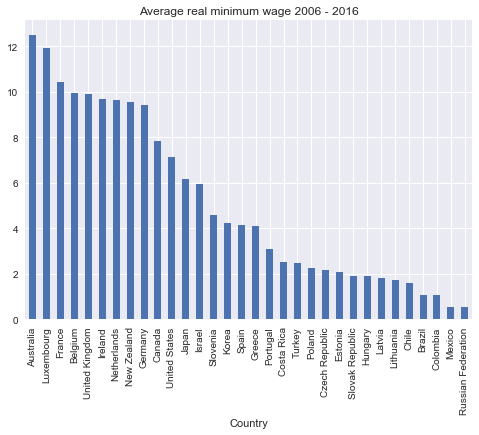

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.style.use('seaborn')

merged.mean().sort_values(ascending=False).plot(kind='bar', title="Average real minimum wage 2006 - 2016")

#Set country labels
country_labels = merged.mean().sort_values(ascending=False).index.get_level_values('Country').tolist()
plt.xticks(range(0, len(country_labels)), country_labels)
plt.xlabel('Country')

plt.show()

Passing in `axis=1` to `.mean()` will aggregate over columns (giving
the average minimum wage for all countries over time)

In [26]:
merged.mean(axis=1).head()

Time
2006-01-01   4.69
2007-01-01   4.84
2008-01-01   4.90
2009-01-01   5.08
2010-01-01   5.11
dtype: float64

We can plot this time series as a line graph

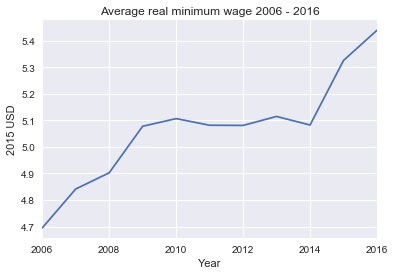

In [27]:
merged.mean(axis=1).plot()
plt.title('Average real minimum wage 2006 - 2016')
plt.ylabel('2015 USD')
plt.xlabel('Year')
plt.show()

We can also specify a level of the `MultiIndex` (in the column axis)
to aggregate over

In [28]:
merged.mean(level='Continent', axis=1).head()

Continent,America,Asia,Australia,Europe
Time,,,,
2006-01-01,2.80,4.29,10.25,4.80
2007-01-01,2.85,4.44,10.73,4.94
2008-01-01,2.99,4.45,10.76,4.99
2009-01-01,3.23,4.53,10.97,5.16
2010-01-01,3.34,4.53,10.95,5.17


We can plot the average minimum wages in each continent as a time series

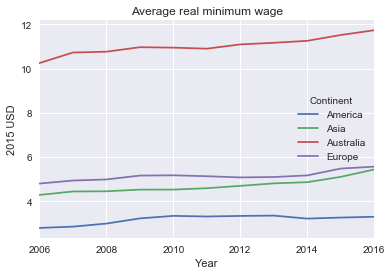

In [29]:
merged.mean(level='Continent', axis=1).plot()
plt.title('Average real minimum wage')
plt.ylabel('2015 USD')
plt.xlabel('Year')
plt.show()

We will drop Australia as a continent for plotting purposes

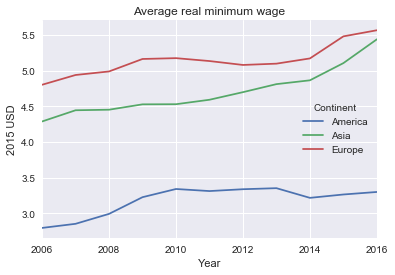

In [30]:
merged = merged.drop('Australia', level='Continent', axis=1)
merged.mean(level='Continent', axis=1).plot()
plt.title('Average real minimum wage')
plt.ylabel('2015 USD')
plt.xlabel('Year')
plt.show()

`.describe()` is useful for quickly retrieving a number of common
summary statistics

In [31]:
merged.stack().describe()

Continent,America,Asia,Europe
count,69.00,44.00,200.00
mean,3.19,4.70,5.15
std,3.02,1.56,3.82
min,0.52,2.22,0.23
25%,1.03,3.37,2.02
50%,1.44,5.48,3.54
75%,6.96,5.95,9.70
max,8.48,6.65,12.39


This is a simplified way to use `groupby`.

Using `groupby` generally follows a ‘split-apply-combine’ process:

- split: data is grouped based on one or more keys  
- apply: a function is called on each group independently  
- combine: the results of the function calls are combined into a new data structure  


The `groupby` method achieves the first step of this process, creating
a new `DataFrameGroupBy` object with data split into groups.

Let’s split `merged` by continent again, this time using the
`groupby` function, and name the resulting object `grouped`

In [32]:
grouped = merged.groupby(level='Continent', axis=1)
grouped

Calling an aggregation method on the object applies the function to each
group, the results of which are combined in a new data structure.

For example, we can return the number of countries in our dataset for
each continent using `.size()`.

In this case, our new data structure is a `Series`

In [33]:
grouped.size()

Continent
America     7
Asia        4
Europe     19
dtype: int64

Calling `.get_group()` to return just the countries in a single group,
we can create a kernel density estimate of the distribution of real
minimum wages in 2016 for each continent.

`grouped.groups.keys()` will return the keys from the `groupby`
object

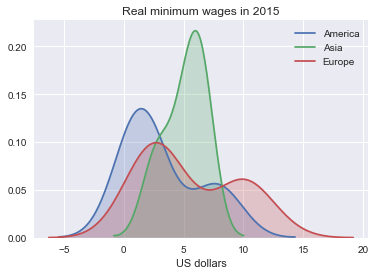

In [34]:
import seaborn as sns

continents = grouped.groups.keys()

for continent in continents:
    sns.kdeplot(grouped.get_group(continent)['2015'].unstack(), label=continent, shade=True)

plt.title('Real minimum wages in 2015')
plt.xlabel('US dollars')
plt.show()

## Final Remarks

This lecture has provided an introduction to some of pandas’ more
advanced features, including multiindices, merging, grouping and
plotting.

Other tools that may be useful in panel data analysis include [xarray](http://xarray.pydata.org/en/stable/), a python package that
extends pandas to N-dimensional data structures.

## Exercises

### Exercise 1

In these exercises, you’ll work with a dataset of employment rates
in Europe by age and sex from [Eurostat](http://ec.europa.eu/eurostat/data/database).

The dataset `pandas_panel/employ.csv` can be downloaded
<a href=_static/lecture_specific/pandas_panel/employ.csv download>here</a>.

Reading in the CSV file returns a panel dataset in long format. Use `.pivot_table()` to construct
a wide format dataframe with a `MultiIndex` in the columns.

Start off by exploring the dataframe and the variables available in the
`MultiIndex` levels.

Write a program that quickly returns all values in the `MultiIndex`.

### Exercise 2

Filter the above dataframe to only include employment as a percentage of
‘active population’.

Create a grouped boxplot using `seaborn` of employment rates in 2015
by age group and sex.

**Hint:** `GEO` includes both areas and countries.

## Solutions

### Exercise 1

In [35]:
employ = pd.read_csv('https://github.com/QuantEcon/QuantEcon.lectures.code/raw/master/pandas_panel/employ.csv')
employ = employ.pivot_table(values='Value',
                            index=['DATE'],
                            columns=['UNIT','AGE', 'SEX', 'INDIC_EM', 'GEO'])
employ.index = pd.to_datetime(employ.index) # ensure that dates are datetime format
employ.head()

UNIT       Percentage of total population                   ...  \
AGE                   From 15 to 24 years                   ...   
SEX                               Females                   ...   
INDIC_EM                Active population                   ...   
GEO                               Austria Belgium Bulgaria  ...   
DATE                                                        ...   
2007-01-01                          56.00   31.60    26.00  ...   
2008-01-01                          56.20   30.80    26.10  ...   
2009-01-01                          56.20   29.90    24.80  ...   
2010-01-01                          54.00   29.80    26.60  ...   
2011-01-01                          54.80   29.80    24.80  ...   

UNIT                                           Thousand persons           \
AGE                                         From 55 to 64 years            
SEX                                                       Total            
INDIC_EM   Total employment (resident population concept - LFS)            
GEO                                                 Switzerland   Turkey   
DATE                                                                       
2007-01-01                                                nan   1,282.00   
2008-01-01                                                nan   1,354.00   
2009-01-01                                                nan   1,449.00   
2010-01-01                                             640.00   1,583.00   
2011-01-01                                             661.00   1,760.00   

UNIT                       
AGE                        
SEX                        
INDIC_EM                   
GEO        United Kingdom  
DATE                       
2007-01-01       4,131.00  
2008-01-01       4,204.00  
2009-01-01       4,193.00  
2010-01-01       4,186.00  
2011-01-01       4,164.00  

[5 rows x 1440 columns]

This is a large dataset so it is useful to explore the levels and
variables available

In [36]:
employ.columns.names

FrozenList(['UNIT', 'AGE', 'SEX', 'INDIC_EM', 'GEO'])

Variables within levels can be quickly retrieved with a loop

In [37]:
for name in employ.columns.names:
    print(name, employ.columns.get_level_values(name).unique())

UNIT Index(['Percentage of total population', 'Thousand persons'], dtype='object', name='UNIT')
AGE Index(['From 15 to 24 years', 'From 25 to 54 years', 'From 55 to 64 years'], dtype='object', name='AGE')
SEX Index(['Females', 'Males', 'Total'], dtype='object', name='SEX')
INDIC_EM Index(['Active population', 'Total employment (resident population concept - LFS)'], dtype='object', name='INDIC_EM')
GEO Index(['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czech Republic',
       'Denmark', 'Estonia', 'Euro area (17 countries)',
       'Euro area (18 countries)', 'Euro area (19 countries)',
       'European Union (15 countries)', 'European Union (27 countries)',
       'European Union (28 countries)', 'Finland',
       'Former Yugoslav Republic of Macedonia, the', 'France',
       'France (metropolitan)',
       'Germany (until 1990 former territory of the FRG)', 'Greece', 'Hungary',
       'Iceland', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg',
       'Malta', 'Neth

### Exercise 2

To easily filter by country, swap `GEO` to the top level and sort the
`MultiIndex`

In [38]:
employ.columns = employ.columns.swaplevel(0,-1)
employ = employ.sort_index(axis=1)

We need to get rid of a few items in `GEO` which are not countries.

A fast way to get rid of the EU areas is to use a list comprehension to
find the level values in `GEO` that begin with ‘Euro’

In [39]:
geo_list = employ.columns.get_level_values('GEO').unique().tolist()
countries = [x for x in geo_list if not x.startswith('Euro')]
employ = employ[countries]
employ.columns.get_level_values('GEO').unique()

Index(['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czech Republic',
       'Denmark', 'Estonia', 'Finland',
       'Former Yugoslav Republic of Macedonia, the', 'France',
       'France (metropolitan)',
       'Germany (until 1990 former territory of the FRG)', 'Greece', 'Hungary',
       'Iceland', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg',
       'Malta', 'Netherlands', 'Norway', 'Poland', 'Portugal', 'Romania',
       'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'Turkey',
       'United Kingdom'],
      dtype='object', name='GEO')

Select only percentage employed in the active population from the
dataframe

In [40]:
employ_f = employ.xs(('Percentage of total population', 'Active population'),
                     level=('UNIT', 'INDIC_EM'),
                     axis=1)
employ_f.head()

GEO                    Austria              ...      United Kingdom        \
AGE        From 15 to 24 years              ... From 55 to 64 years         
SEX                    Females Males Total  ...             Females Males   
DATE                                        ...                             
2007-01-01               56.00 62.90 59.40  ...               49.90 68.90   
2008-01-01               56.20 62.90 59.50  ...               50.20 69.80   
2009-01-01               56.20 62.90 59.50  ...               50.60 70.30   
2010-01-01               54.00 62.60 58.30  ...               51.10 69.20   
2011-01-01               54.80 63.60 59.20  ...               51.30 68.40   

GEO               
AGE               
SEX        Total  
DATE              
2007-01-01 59.30  
2008-01-01 59.80  
2009-01-01 60.30  
2010-01-01 60.00  
2011-01-01 59.70  

[5 rows x 306 columns]

Drop the ‘Total’ value before creating the grouped boxplot

In [41]:
employ_f = employ_f.drop('Total', level='SEX', axis=1)

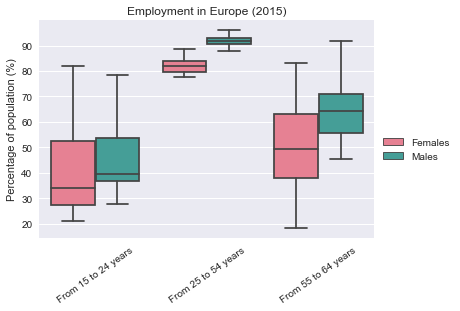

In [42]:
box = employ_f['2015'].unstack().reset_index()
sns.boxplot(x="AGE", y=0, hue="SEX", data=box, palette=("husl"), showfliers=False)
plt.xlabel('')
plt.xticks(rotation=35)
plt.ylabel('Percentage of population (%)')
plt.title('Employment in Europe (2015)')
plt.legend(bbox_to_anchor=(1,0.5))
plt.show()